# Layered Network

##### Imports

In [17]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'modules')))
from hh_model import HodgkinHuxleyNeuron

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

### Single Network

##### Directed Erdos-Renyi Graph

In [18]:
def generate_erdos_renyi_digraph(n, p, s=''):
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Add nodes with custom names
    names = [s + str(i) for i in range(n)]
    for name in names:
        G.add_node(name)  # Assuming HodgkinHuxleyNeuron() is defined elsewhere
    
    # Add edges based on Erdos-Renyi probability
    for i, u in enumerate(names):
        for j, v in enumerate(names):
            if i != j and random.random() < p:
                G.add_edge(u, v)
    
    # Remove bidirectional edges
    for u, v in list(G.edges()):
        if G.has_edge(v, u):
            G.remove_edge(v, u)
    
    # Create neuron objects
    for node in G.nodes():
        G.nodes[node]['neuron'] = HodgkinHuxleyNeuron()
    
    return G

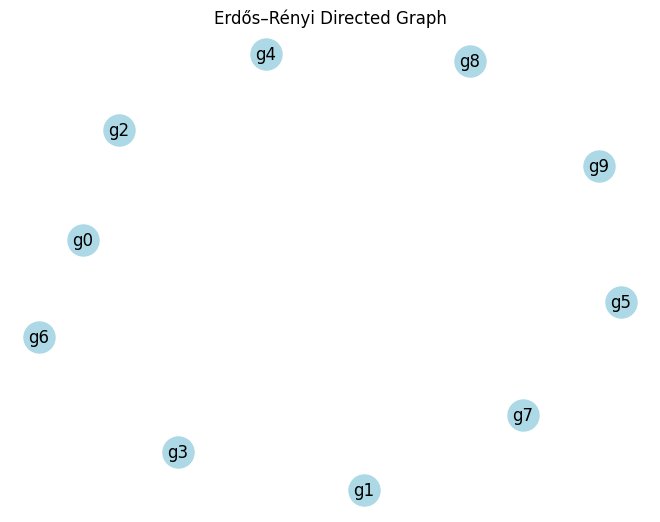

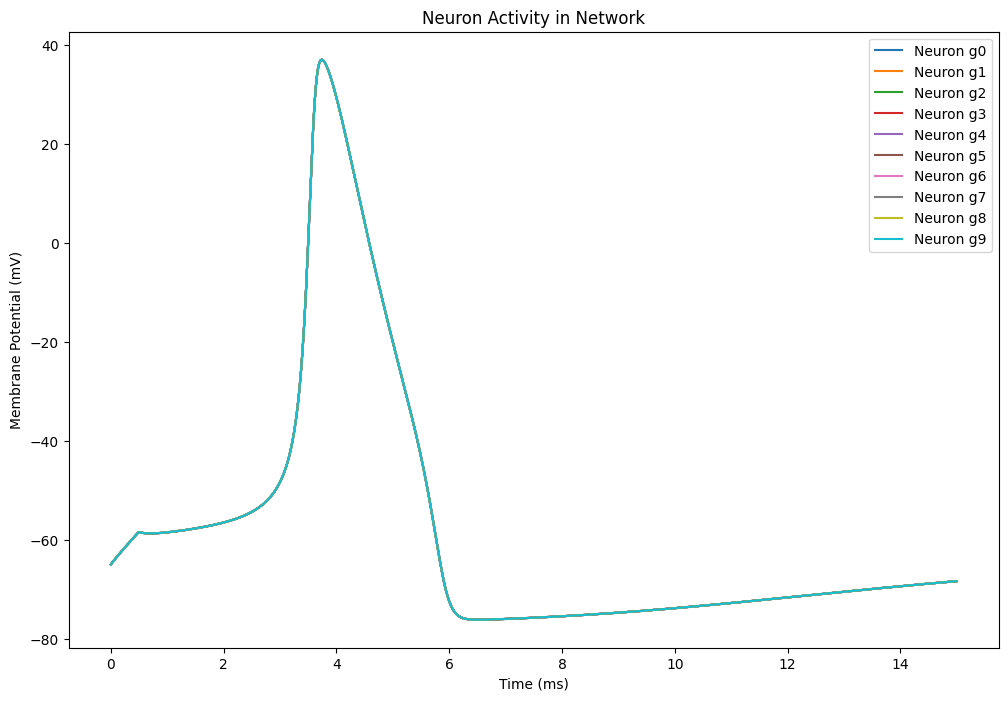

In [19]:
g = generate_erdos_renyi_digraph(10, 0, s='g')

# Draw the graph
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()


# Parameters
T = 15.0
dt = 0.01
time = np.arange(0, T, dt)

I_inp = np.zeros(len(time))
I_inp[int(0/dt):int(0.5/dt)] = 15.0
I_inp[0] = 0

# Record data
V = {}
nodes = g.nodes()
for node in nodes:
        V[node] = []

Network = g.nodes()
for i in range(len(time)):
    for node in Network:
        neuron = Network[node]['neuron']
        neuron.step(dt, I_inp[i])
        V[node].append(neuron.V)


# Plotting results
plt.figure(figsize=(12, 8))
for node, voltages in V.items():
    plt.plot(time, voltages, label=f'Neuron {node}')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Neuron Activity in Network")
plt.show()


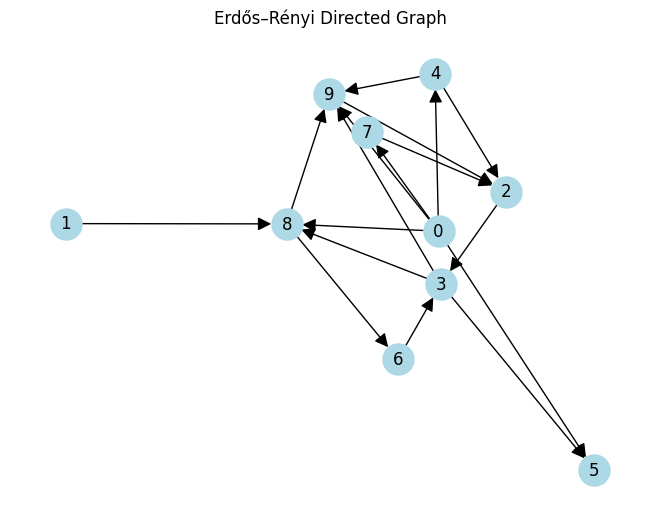

In [20]:
# Parameters
n = 10
p = 0.3

# Generate the graph
digraph = generate_erdos_renyi_digraph(n, p)

# Draw the graph
pos = nx.spring_layout(digraph)
nx.draw(digraph, pos, with_labels=True, node_color='lightblue', node_size=500, arrowsize=20)
plt.title("Erdős–Rényi Directed Graph")
plt.show()

In [21]:
print(digraph.nodes()['0'])

{'neuron': <hh_model.HodgkinHuxleyNeuron object at 0x7ab07150f0a0>}


##### Layered Network

0.2


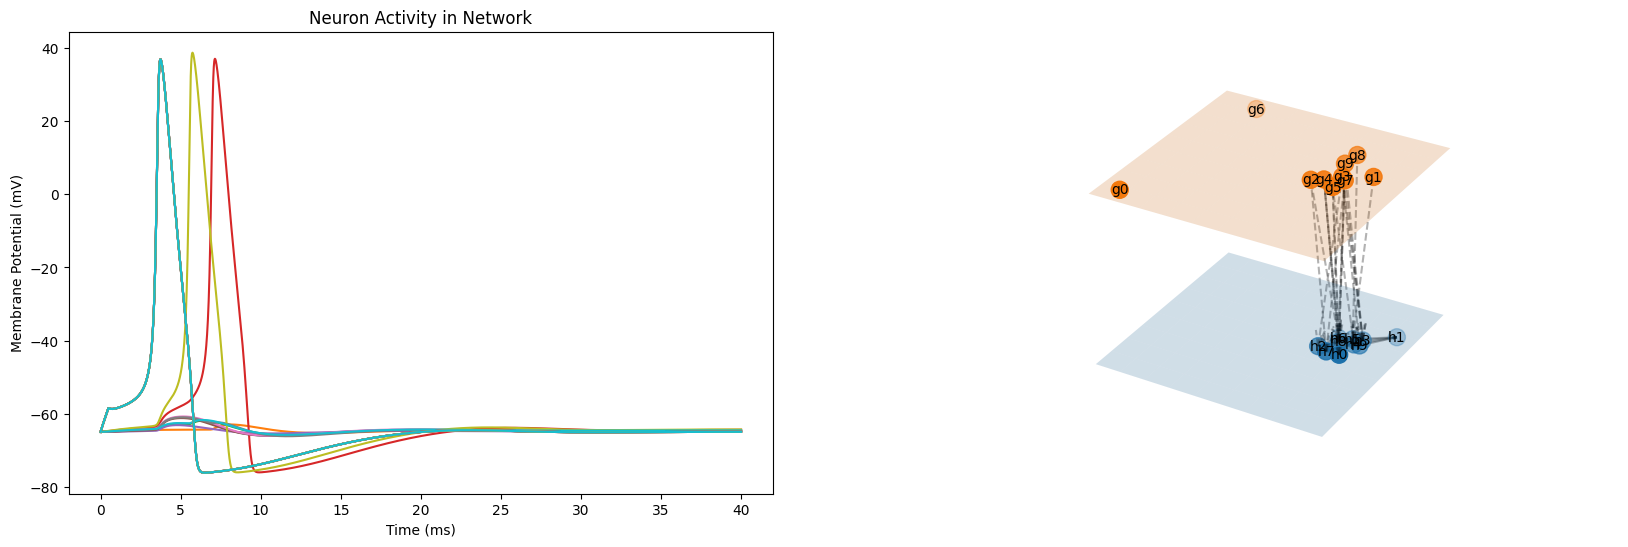

In [25]:
class LayeredNetworkGraph(object):

    def __init__(self, layers, inter_prob=0.0, layout=nx.spring_layout, ax=None, verbose=False):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.layers = layers
        # self.graphs = graphs
        self.total_layers = len(layers)

        self.inter_prob = inter_prob
        self.layout = layout


        # create internal representation of nodes and edges
        self.get_graphs()
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()

        if verbose:
            # Run your function
            obj = self.run()
            print(obj)

            # Create a figure with 1 row and 2 columns for subplots
            fig, axes = plt.subplots(1, 2, figsize=(20, 6))

            # Assign axes[1] to the 3D plot
            axes[1].set_axis_off()
            self.ax = fig.add_subplot(122, projection='3d')  # Assign 3D subplot to axes[1]
            self.ax.set_axis_off()  # Turn off the entire axis (including labels and ticks)

            # Call the draw function for the 3D plot
            self.draw()

            # Plot the 2D results on axes[0]
            axes[0].set_xlabel("Time (ms)")
            axes[0].set_ylabel("Membrane Potential (mV)")
            axes[0].set_title("Neuron Activity in Network")

            # Plotting the 2D data for each neuron on axes[0]
            T = 40.0
            dt = 0.01
            time = np.arange(0, T, dt)

            for node, voltages in self.V_record.items():
                min_len = min(len(time), len(voltages))  # Ensure time and voltages have the same length
                axes[0].plot(time[:min_len], voltages[:min_len], label=f'Neuron {node}')

            # axes[0].legend()

            # Show the plot
            plt.show()

    def generate_erdos_renyi_digraph(self, n, p, s=''):
        # Create an empty directed graph
        G = nx.DiGraph()

        # Add nodes with custom names
        names = [s + str(i) for i in range(n)]
        for name in names:
            # Assuming HodgkinHuxleyNeuron() is defined elsewhere
            G.add_node(name)

        # Add edges based on Erdos-Renyi probability
        for i, u in enumerate(names):
            for j, v in enumerate(names):
                if i != j and random.random() < p:
                    G.add_edge(u, v)

        # Remove bidirectional edges
        for u, v in list(G.edges()):
            if G.has_edge(v, u):
                G.remove_edge(v, u)

        # Create neuron objects
        for node in G.nodes():
            G.nodes[node]['neuron'] = HodgkinHuxleyNeuron()

        return G

    def get_graphs(self):
        self.graphs = []

        for n, p, s in self.layers:
            self.graphs.append(self.generate_erdos_renyi_digraph(n, p, s))



    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []

        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])

        self.update = {}
        for g in self.graphs:
            self.update[g]= list(g.nodes())
                
        

    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])

    def get_edges_between_layers(self):
        """Forms connections between nodes from different layers, thus connecting the layers"""
        self.edges_between_layers = []
        for z1, h in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            g = self.graphs[z2]

            h_nodes = list(h.nodes())

            for node1 in g.nodes():
                for node2 in h_nodes:
                    if random.random() < self.inter_prob:
                        h.add_node(node1)
                        h.nodes[node1]['neuron'] = g.nodes[node1]['neuron']
                        h.add_edge(node1, node2)
                        self.edges_between_layers.append(((node1, z2), (node2, z1)))


    def get_node_positions(self, *args, **kwargs):
        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        # Hardcoded arrow size
        arrow_size = 0.1  # Control the size of the arrowhead here
        
        # Extract color from kwargs if it's passed
        color = kwargs.get('color', 'blue')  # Default to 'blue' if not provided
        
        # Remove 'color' from kwargs to avoid conflict
        kwargs = {key: value for key, value in kwargs.items() if key != 'color'}

        for source, target in edges:
            # print((source, target)) 
            start = self.node_positions[source]
            end = self.node_positions[target]

            # Calculate direction vector
            direction = np.array(end) - np.array(start)  
            length = np.linalg.norm(direction)
            direction /= length  # Normalize direction

            # Set up the quiver to draw arrows
            self.ax.quiver(start[0], start[1], start[2], 
                           direction[0], direction[1], direction[2], 
                           length=length, color=color, 
                           arrow_length_ratio=arrow_size, *args, **kwargs)

    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, *args, **kwargs):
        for node, z in self.nodes:
            self.ax.text(*self.node_positions[(node, z)], node, *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=150, zorder=3)

        self.draw_node_labels(horizontalalignment='center',
                              verticalalignment='center',
                              zorder=100)

    def run(self):
        # Parameters
        T = 40.0
        dt = 0.01
        time = np.arange(0, T, dt)

        I_inp = np.zeros(len(time))
        I_inp[int(0/dt):int(0.5/dt)] = 15.0
        I_inp[0] = 0

        # Post-Synaptic Constants
        tau = 30
        weight = 0.1
        
        V_record = {}
        for nodes in self.update.values():  # Iterate over the lists of nodes in self.update
            for node in nodes:
                V_record[node] = []

        
        total_endpoints = len(self.update[self.graphs[0]])
        endpoint_reached = 0


        for i in range(len(time)):
            for g in self.graphs[::-1]:
                nodes = self.update[g]
                Network = g.nodes()
                for node in nodes:
                    I_temp = 0.0
                    neuron = Network[node]['neuron']

                    if g == self.graphs[-1]:
                        neuron.step(dt, I_inp[i])
                        V_record[node].append(neuron.V)
                    elif g == self.graphs[0]:
                        for pred in list(g.predecessors(node)):
                            parent = Network[pred]['neuron']
                            I_temp += weight * np.exp(-(neuron.V - parent.V) / tau)

                        neuron.step(dt, I_temp)
                        V_record[node].append(neuron.V)

                        # Find peak
                        if i > 3 and V_record[node][-3] < V_record[node][-2] and V_record[node][-2] > V_record[node][-1]:
                            if V_record[node][-2] > 20.0:
                                endpoint_reached += 1
                    else:
                        for pred in list(g.predecessors(node)):
                            parent = Network[pred]['neuron']
                            I_temp += weight * np.exp(-(neuron.V - parent.V) / tau)

                        neuron.step(dt, I_temp)
                        V_record[node].append(neuron.V)
        
        self.V_record = V_record

        return endpoint_reached / total_endpoints



n = 10
g = generate_erdos_renyi_digraph(n, p=0, s='g')
h = generate_erdos_renyi_digraph(n, p=0.5, s='h')
i = generate_erdos_renyi_digraph(n, p=0, s='i')
prob_inter = 0.2
obj = LayeredNetworkGraph([(n, 0, 'g'), (n, 0.5, 'h')][::-1], prob_inter, layout=nx.spring_layout, verbose=True)